# Robotic Systems 1 - Homework 2

In [1]:
import numpy as np # Linear Algebra
import pinocchio as pin # Pinocchio library
import os
import time
import helpers as hp
import proxsuite
import matplotlib.pyplot as plt

from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.visualize import MeshcatVisualizer

VISUALIZER = MeshcatVisualizer

In [2]:
def load_franka():
  current_path = os.path.abspath('') # where the folder `robot` is located at
  robot_path = os.path.join(current_path, "robot")

  robot = RobotWrapper.BuildFromURDF(os.path.join(robot_path, "franka.urdf"), package_dirs = robot_path)

  return robot

In [3]:
def step_world(model, data, t_q, t_qdot, t_tau, t_dt):
  
  qdotdot = pin.aba(model, data, t_q, t_qdot, t_tau)
  q_dot = t_qdot + qdotdot*t_dt
  q_dot = np.clip(q_dot, -model.velocityLimit, model.velocityLimit)
  q = pin.integrate(model, t_q, q_dot*t_dt)
  q = np.clip(q, model.lowerPositionLimit, model.upperPositionLimit)
  
  return q, q_dot

In [4]:
robot = load_franka()

model = robot.model
data = robot.data
end_effector = model.getFrameId("panda_ee")

robot.setVisualizer(VISUALIZER())
robot.initViewer()
robot.loadViewerModel("pinocchio")

robot.display(pin.randomConfiguration(model))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


## Task-Space Trajectories

I should implement 4 different profiles. I decided to do them in 4 different ways. So we have:
- Screw Path
- Decoupled trajectory
- The above with third order polynomials for time scaling


Questions:
- orientation and translation error should be computed separately in the controller -> straight lines in the task space (not on the SO3 manifold) but what if the trajectory is computed on the manifold? (screw path(on the SO3 manifold) and decoupled rot and trans)

In [51]:
# def get_Twd(start, goal, t_t, T):
#   return pin.SE3.Interpolate(start, goal, min(1, t_t/T))

def get_Twd(start, goal, t_t, T):
  Twd = pin.SE3.Interpolate(start, goal, min(1, t_t/T))
  Twd.translation = hp.interpolate_translation(start.translation, goal.translation, min(1,t_t/T))
  return Twd

def get_Twd(start, goal, t_t, T):
  s = 3*(t_t/T)**2 -2*(t_t/T)**3
  Twd = pin.SE3.Interpolate(start, goal, s)
  Twd.translation = hp.interpolate_translation(start.translation, goal.translation, s)
  return Twd

# def get_Twd(start, goal, t_t, T):
#   s = 3*(t_t/T)**2 -2*(t_t/T)**3
#   # return pin.SE3.Interpolate(start, goal, min(1, time/T))
#   return pin.SE3.Interpolate(start, goal, s)

# def get_Twd(start, goal, t_t, T):
#   s = 3*(t_t/T)**2 -2*(t_t/T)**3
#   # return pin.SE3.Interpolate(start, goal, min(1, time/T))
#   return pin.SE3.Interpolate(start, goal, s)

## Task-Space Controller

In [6]:
pin.seed(4)
A = pin.SE3.Random()
B = pin.SE3.Random()



def compute_error(Td, Tb):
  # error = pin.Motion()
  error = pin.log(Td * pin.SE3.inverse(Tb))
  # print(error.angular)
  # print(pin.log(Td.rotation @ Tb.rotation.T))
  
  error.linear = Td.translation - Tb.translation
  
  # out_error = np.zeros((6,))
  # out_error[:3] = error.linear
  # out_error[3:] = error.angular

  # print(out_error)

  return error.vector

compute_error(A,B)

array([-0.09929022, -0.58518274,  0.49099008, -0.03900671, -1.26252876,
       -1.93975313])

In [49]:
prev_error = None
sum_error = 0.
init = True



def controller(model, data, t_q, t_qdot, t_Twd, t_dt, Kp=100., Ki=1000., Kd= 100.):
    global prev_error
    global sum_error
    global init

    pin.crba(model, data, t_q)
    pin.nonLinearEffects(model, data, t_q, t_qdot)
    

    hp.fk_all(model, data, t_q)

    Twb = data.oMf[end_effector].copy()

    error = compute_error(t_Twd, Twb)

    if init:
        prev_error = np.copy(error)
        init = False

    sum_error += (error * t_dt)
    
    J = pin.computeFrameJacobian(model, data, t_q, end_effector, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    dJ = pin.getFrameJacobianTimeVariation(model, data, end_effector, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)

    J_Tpinv = hp.damped_pseudoinverse(J.T)
    J_pinv = hp.damped_pseudoinverse(J)


    Lamda = J_Tpinv @ data.M @ J_pinv
    hta = J_Tpinv @ data.nle - Lamda @ dJ @ t_qdot


    F_w = Lamda@(Kp*error + Ki*sum_error + Kd*(error-prev_error)/t_dt) + hta
    # F_w = Kp*error + Ki*sum_error + Kd*(error-prev_error)/t_dt
    prev_error = np.copy(error)


    #Null space controller - regularization
    q_target = (model.upperPositionLimit - model.lowerPositionLimit) / 2. + model.lowerPositionLimit

    reg_error = (q_target - t_q)

    t_reg = 10. * reg_error
    

    # tau = hp.damped_pseudoinverse(J) @ F_w# + (np.eye(model.nv) - J.T @ J_Tpinv) @ t_reg

    tau = J.T @ F_w + (np.eye(model.nv) - J.T @ J_Tpinv) @ t_reg



    return tau
  
  

## Simulation

final position error:
  R =
   0.999995 -0.00286085  0.00126904
 0.00286564    0.999989 -0.00378823
-0.00125818  0.00379185    0.999992
  p =  0.000452283   0.00036623 -0.000680035



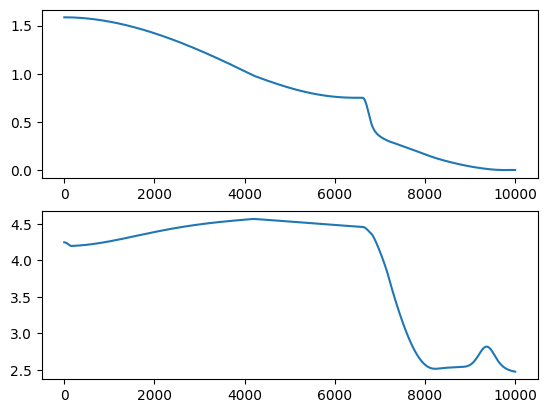

In [52]:
T = 10.
dt = 0.001
K = int(T/dt) + 1
prev_error = None
sum_error = 0.
init = True
t = 0
k = 0

error_ = []
reg_error_ = []
q_reg = (model.upperPositionLimit - model.lowerPositionLimit) / 2. + model.lowerPositionLimit

pin.seed(6)
q = pin.randomConfiguration(model)
qdot = np.zeros(model.nv)
tau = np.zeros(model.nv)

hp.fk_all(model,data,q)
T_start = data.oMf[end_effector].copy()

T_end = T_start.copy()
T_end.translation = T_start.translation + [0.,-0.1,+0.2]
T_end.rotation = hp.RotZ(-np.pi/2) @  T_start.rotation


robot.display(q)
time.sleep(1)

for k in range(K):
  Twd = get_Twd(T_start, T_end, t, T)

  tau = controller(model, data, q, qdot, Twd, dt, 10000., 100., 1000.)
  error_.append(np.linalg.norm(compute_error(T_end, data.oMf[end_effector])))
  reg_error_.append(reg_er)

  q , qdot  = step_world(model, data, q, qdot, tau, dt)

  if np.mod(k, 100)==0:
    robot.display(q)

  t += dt
  k +=1
  
print("final position error:")
print(pin.exp(compute_error(T_end, data.oMf[end_effector])))

plt.subplot(2,1,1)
plt.plot(error_)
plt.subplot(2,1,2)
plt.plot(reg_error_)


Simple algorithm